# Setup

In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ------------------------------------- 949.2/949.2 kB 45.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 90.2 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15703 sha256=94a7c73e691ba1665b31c25cba1204db2710c4a0fb57e620bb1ebb1b462640a2
  Stored in directory: c:\us

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Experimental Setup

In [3]:
# Math and data preprocessing libraries
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# For handling dataset
import yfinance as yf
from datetime import date

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For evaluation
from sklearn.metrics \
import root_mean_squared_error, mean_absolute_percentage_error

## Configure GPU Settings

In [4]:
device = torch.device('cuda' if \
                      torch.cuda.is_available() else 'cpu')

print(device)

cuda


# Data Preprocessing

## Dataset Preparation

In [5]:
start_date = '2020-01-01'
end_date = '2024-12-31'

df = yf.download('GOOG', start=start_date, end=end_date)

# Inspect the data
print()
print(df.head())
print(df.info())

C:\Users\swsuser-k06\AppData\Local\Temp\ipykernel_10476\2146223092.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('GOOG', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                            
2020-01-02  67.964508  68.002778  66.681136  66.681136  28132000
2020-01-03  67.630989  68.219494  66.879657  66.994771  23728000
2020-01-06  69.298584  69.412402  67.101143  67.101143  34646000
2020-01-07  69.255341  69.734988  69.108212  69.483985  30054000
2020-01-08  69.801094  70.161948  69.131073  69.192703  30560000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GOOG)   1257 non-null   float64
 1   (High, GOOG)    1257 non-null   float64
 2   (Low, GOOG)     1257 non-null   float64
 3   (Open, GOOG)    1257 non-null   float64
 4   (Volume, GOOG)  1257 non-null   int64  
dtypes: float64(4), int64(1)
memory usag

## Data Visualization

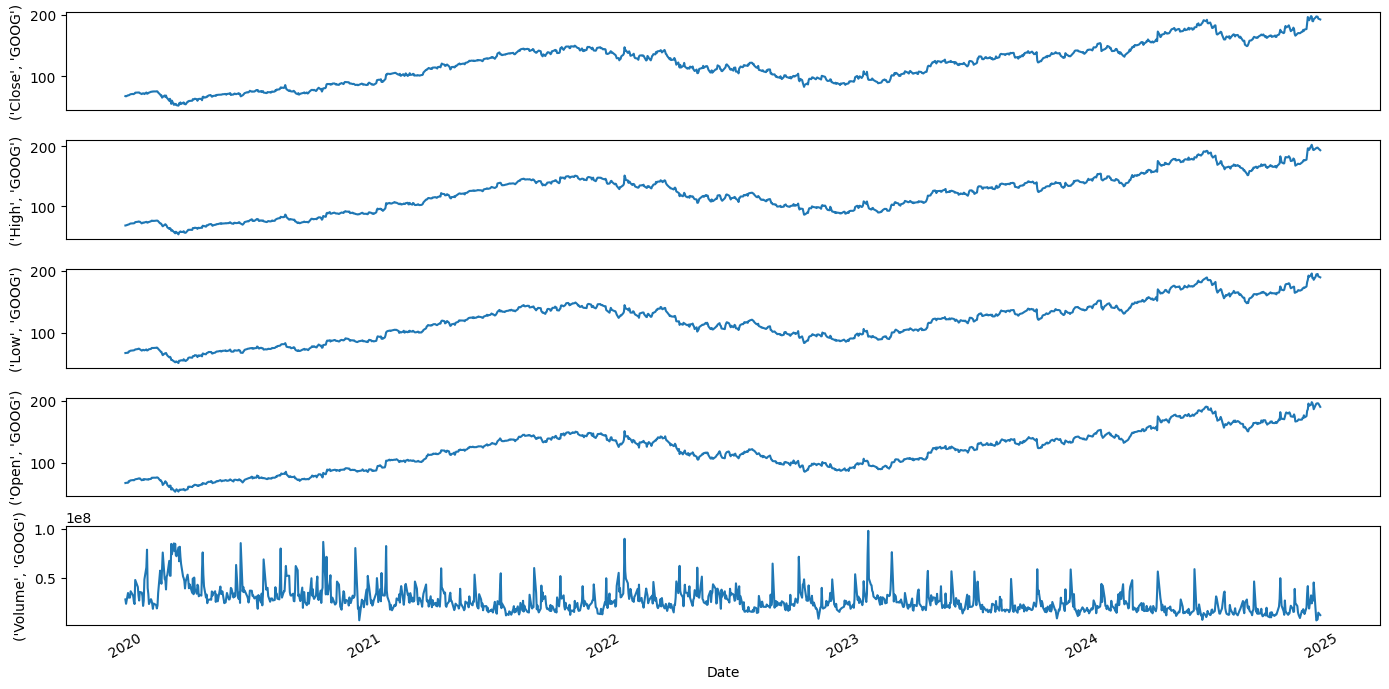

In [6]:
ncols = 1
nrows = int(round(df.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, \
                       sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, \
                   labelsize=10, length=0)
fig.tight_layout()
plt.show()

## Train-Test Split

In [7]:
# Train test split
train_ratio = 0.8
training_data_len = math.ceil(len(df) * train_ratio)

# Splitting the dataset
train_data = df[:training_data_len][['Open']]
test_data = df[training_data_len:][['Open']]
print(train_data.shape)
print(test_data.shape)

# (1006, 1)
# (251, 1)

(1006, 1)
(251, 1)


## Scaling the Data

In [8]:
# Scaling dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values)
test_scaled = scaler.transform(test_data.values)

for v in train_data.values[:5, 0]:
  print(f'{v:6.3f}', end=' ')
print()
# 66.681 66.995 67.101 69.484 69.193

for v in train_scaled[:5, 0]:
  print(f'{v:6.3f}', end=' ')
print()
# 0.144  0.147  0.148  0.172  0.169

66.681 66.995 67.101 69.484 69.193 
 0.144  0.147  0.148  0.172  0.169 


## Sliding Window

In [9]:
sequence_length = 50  # Number of time steps to look back

def convert_data_into_tensors(data_seq):
  features, labels = [], []
  for i in range(len(data_seq) - sequence_length):
      features.append(data_seq[i:i + sequence_length])
      labels.append(data_seq[i + sequence_length, 0])
  features, labels = np.array(features), np.array(labels)

  features = torch.tensor(features, dtype=torch.float32)
  labels = torch.tensor(labels, dtype=torch.float32)
  return features, labels

X_train, y_train = convert_data_into_tensors(train_scaled)
X_test, y_test = convert_data_into_tensors(test_scaled)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# torch.Size([956, 50, 1])
# torch.Size([956])
# torch.Size([201, 50, 1])
# torch.Size([201])

torch.Size([956, 50, 1])
torch.Size([956])
torch.Size([201, 50, 1])
torch.Size([201])


## Batching the Data

In [10]:
batch_size = 32

def to_loader(x, y, batch_size, shuffle):
  dataset = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(dataset, batch_size, shuffle)

train_loader = to_loader(X_train, y_train, batch_size, shuffle=True)
test_loader = to_loader(X_test, y_test, batch_size, shuffle=False)

print(train_loader)
print(test_loader)

# <torch.utils.data.dataloader.DataLoader object at 0x78eacd13fdd0>
# <torch.utils.data.dataloader.DataLoader object at 0x78eacd13fd50>

# Practice

In [11]:
# set random seed

manual_seed = 42
torch.manual_seed(manual_seed)
np.random.seed(manual_seed)

## Model: LSTM

In [12]:
input_size = X_train.shape[-1]
num_layers = 2
hidden_size = 64

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # (lstm): LSTM(1, 64, num_layers=2, batch_first=True)

        self.linear = nn.Linear(hidden_size, 1)
        # (linear): Linear(in_features=64, out_features=1, bias=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out)

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


### Training


Epoch  1/10 - Training Loss: 0.1736, Test Loss: 0.4874
Epoch  2/10 - Training Loss: 0.0388, Test Loss: 0.0877
Epoch  3/10 - Training Loss: 0.0078, Test Loss: 0.0072
Epoch  4/10 - Training Loss: 0.0031, Test Loss: 0.0097
Epoch  5/10 - Training Loss: 0.0023, Test Loss: 0.0123
Epoch  6/10 - Training Loss: 0.0020, Test Loss: 0.0188
Epoch  7/10 - Training Loss: 0.0020, Test Loss: 0.0111
Epoch  8/10 - Training Loss: 0.0021, Test Loss: 0.0165
Epoch  9/10 - Training Loss: 0.0018, Test Loss: 0.0225
Epoch 10/10 - Training Loss: 0.0017, Test Loss: 0.0177


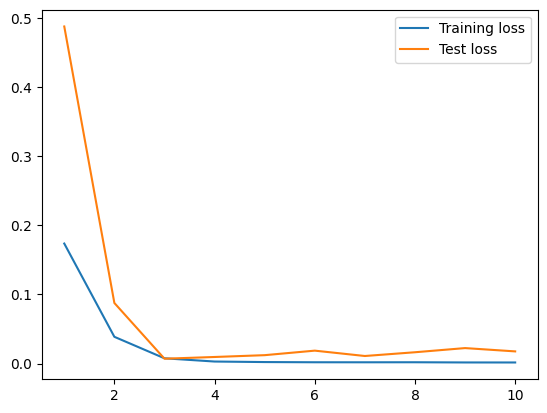

In [13]:
def train(model, train_loader, test_loader):
  train_hist = []
  test_hist = []
  num_epochs = 10
  loss_fn = nn.MSELoss(reduction='mean')
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_test_loss = 0.0

    # train
    model.train()
    for batch_x, batch_y in train_loader:
      # (1) Move input and target tensors to the device (e.g., GPU)
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # (2) Pass the input (batch_x) through the model
      #     The model outputs shape [batch_size, sequence_length, 1]
      #     Take the prediction at the last timestep (index -1) and feature index 0
      #     → model(batch_x)[:, -1, 0]
      pred = model(batch_x)[:, -1, 0]

      # (3) Compute the loss between pred and batch_y by using loss_fn
      loss = loss_fn(pred, batch_y)

      # (4) Clear previous gradients to avoid accumulation
      optimizer.zero_grad()

      # (5) Perform backpropagation to compute gradients
      loss.backward()

      # (6) Update the model parameters using the optimizer
      optimizer.step()

      total_train_loss += loss.item()

    avg_loss = total_train_loss / len(train_loader)
    train_hist.append(avg_loss)

    # evaluate
    model.eval()
    with torch.no_grad():
      for test_x, test_y in test_loader:
        # TODO
        # (1) Move input and target tensors to the device (e.g., GPU)
        test_x, test_y = test_x.to(device), test_y.to(device)

        # (2) Pass the input (test_x) through the model
        #     The model outputs shape [batch_size, sequence_length, 1]
        #     Take the prediction at the last timestep (index -1) and feature index 0
        #     → model(test_x)[:, -1, 0]
        test_pred = model(test_x)[:, -1, 0]

        # (3) Compute the loss between test_pred and test_y by using loss_fn
        test_loss = loss_fn(test_pred, test_y)

        total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_hist.append(avg_test_loss)

    print(f'Epoch {epoch + 1:2d}/{num_epochs} - Training Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

  x = np.linspace(1, num_epochs, num_epochs)
  plt.plot(x, train_hist, scalex=True, label="Training loss")
  plt.plot(x, test_hist, label="Test loss")
  plt.legend()

train(model, train_loader, test_loader)

# Epoch  1/10 - Training Loss: 0.1736, Test Loss: 0.4874
# Epoch  2/10 - Training Loss: 0.0388, Test Loss: 0.0877
# Epoch  3/10 - Training Loss: 0.0078, Test Loss: 0.0072
# Epoch  4/10 - Training Loss: 0.0031, Test Loss: 0.0097
# Epoch  5/10 - Training Loss: 0.0023, Test Loss: 0.0123
# Epoch  6/10 - Training Loss: 0.0020, Test Loss: 0.0188
# Epoch  7/10 - Training Loss: 0.0020, Test Loss: 0.0111
# Epoch  8/10 - Training Loss: 0.0021, Test Loss: 0.0165
# Epoch  9/10 - Training Loss: 0.0018, Test Loss: 0.0225
# Epoch 10/10 - Training Loss: 0.0017, Test Loss: 0.0177

### Forecasting Visualization

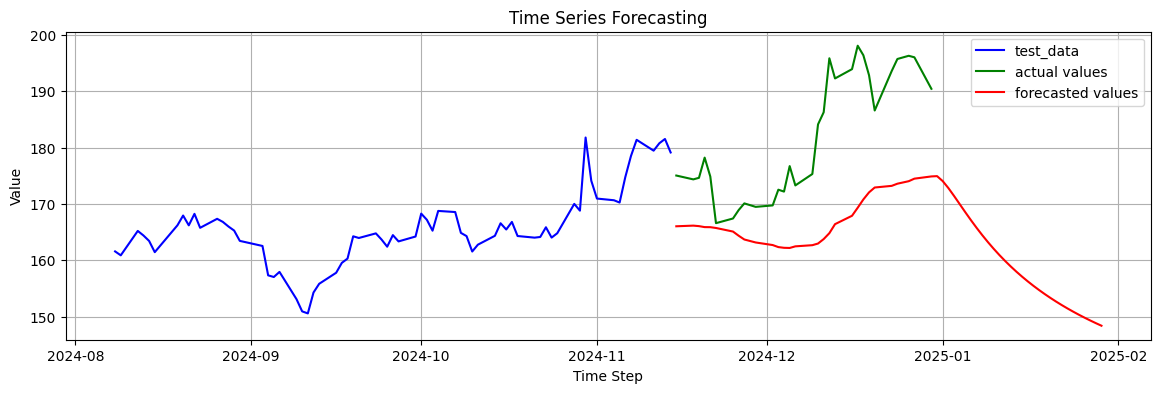

In [14]:
def plot_forecasting(model, X_test, y_test):
  model.eval()
  num_forecast_steps = 30
  input_data = X_test[-num_forecast_steps].cpu().numpy().squeeze()

  forecasted_values = []
  with torch.no_grad():
    for i in range(2 * num_forecast_steps):
      input_tensor = torch.as_tensor(input_data).view(1, -1, 1).to(device)
      predicted = model(input_tensor)[0, -1, 0].item()

      forecasted_values.append(predicted)
      input_data = np.roll(input_data, shift=-1)

      if i < num_forecast_steps:
        input_data[-1] = y_test[-num_forecast_steps + i]
      else:
        input_data[-1] = predicted

  df_out = df.copy()
  last_date = df_out.index[-1]
  future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)
  combined_dates = df_out.index.append(future_dates)
  plt.rcParams['figure.figsize'] = [14, 4]
  plt.plot(test_data.index[-100:-30], test_data[-100:-30], label = "test_data", color = "b")
  plt.plot(test_data.index[-30:], test_data.iloc[-30:], label='actual values', color='green')

  forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
  plt.plot(combined_dates[-60:], forecasted_cases, label='forecasted values', color='red')

  plt.xlabel('Time Step')
  plt.ylabel('Value')
  plt.legend()
  plt.title('Time Series Forecasting')
  plt.grid(True)

plot_forecasting(model, X_test, y_test)

### Test

In [20]:
def test(model, X_test, y_test):
  model.eval()
  with torch.no_grad():
      test_predictions = []
      for batch_X_test in X_test:
          batch_X_test = batch_X_test.to(device).unsqueeze(0)
          test_predictions.append(model(batch_X_test) \
                                  .cpu().numpy().flatten()[0])

  test_predictions = np.array(test_predictions)
  y_test = y_test.cpu().numpy()

  rmse = root_mean_squared_error(y_test, test_predictions) # TODO
  mape = mean_absolute_percentage_error(y_test, test_predictions) # TODO

  return rmse, mape

rmse, mape = test(model, X_test, y_test)
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')

# RMSE: 1.1711
# MAPE: 0.9778

RMSE: 0.7512
MAPE: 0.6184


#Other Models: CNN, RNN

In [21]:
class Conv1DModel(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Conv1DModel, self).__init__()
    # TODO
    self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, \
                            kernel_size=2, stride=1)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = x.transpose(1, 2)
    x = self.conv1d(x)
    x = x.transpose(1, 2)
    return self.fc(x)

In [22]:
input_size = X_train.shape[-1]
num_layers = 2
hidden_size = 64

model = Conv1DModel(input_size, hidden_size).to(device)

print(model)

Conv1DModel(
  (conv1d): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch  1/10 - Training Loss: 0.1804, Test Loss: 0.0111
Epoch  2/10 - Training Loss: 0.0074, Test Loss: 0.0084
Epoch  3/10 - Training Loss: 0.0012, Test Loss: 0.0019
Epoch  4/10 - Training Loss: 0.0006, Test Loss: 0.0015
Epoch  5/10 - Training Loss: 0.0006, Test Loss: 0.0015
Epoch  6/10 - Training Loss: 0.0006, Test Loss: 0.0016
Epoch  7/10 - Training Loss: 0.0006, Test Loss: 0.0015
Epoch  8/10 - Training Loss: 0.0006, Test Loss: 0.0015
Epoch  9/10 - Training Loss: 0.0006, Test Loss: 0.0015
Epoch 10/10 - Training Loss: 0.0006, Test Loss: 0.0015


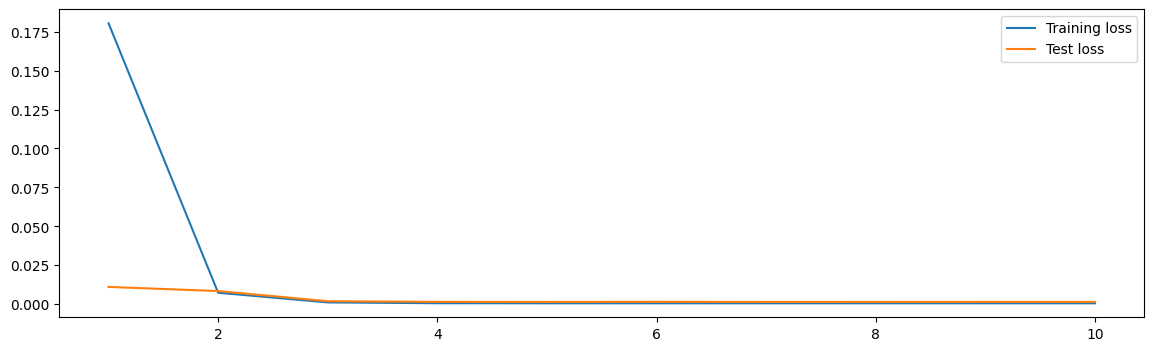

In [23]:
train(model, train_loader, test_loader)

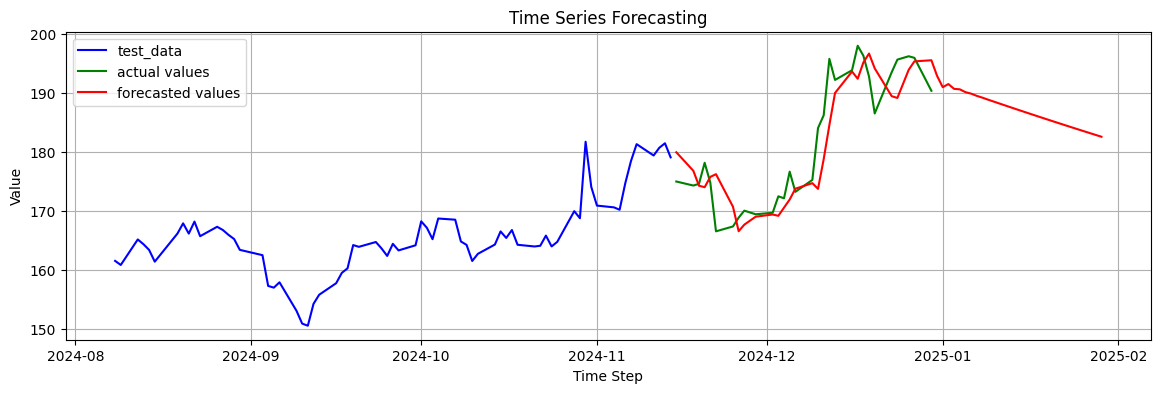

In [24]:
plot_forecasting(model, X_test, y_test)

In [25]:
rmse, mape = test(model, X_test, y_test)
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')

RMSE: 0.2051
MAPE: 0.1450


In [30]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
      super(RNNModel, self).__init__()
      # TODO
      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
      # TODO
      out, _ = self.rnn(x)
      return self.fc(out)


In [31]:
input_size = X_train.shape[-1]
num_layers = 2
hidden_size = 64

model = RNNModel(input_size, hidden_size, num_layers).to(device)

print(model)

RNNModel(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch  1/10 - Training Loss: 0.0810, Test Loss: 0.1009
Epoch  2/10 - Training Loss: 0.0100, Test Loss: 0.0321
Epoch  3/10 - Training Loss: 0.0014, Test Loss: 0.0154
Epoch  4/10 - Training Loss: 0.0010, Test Loss: 0.0127
Epoch  5/10 - Training Loss: 0.0009, Test Loss: 0.0100
Epoch  6/10 - Training Loss: 0.0009, Test Loss: 0.0103
Epoch  7/10 - Training Loss: 0.0009, Test Loss: 0.0093
Epoch  8/10 - Training Loss: 0.0010, Test Loss: 0.0092
Epoch  9/10 - Training Loss: 0.0009, Test Loss: 0.0076
Epoch 10/10 - Training Loss: 0.0008, Test Loss: 0.0080


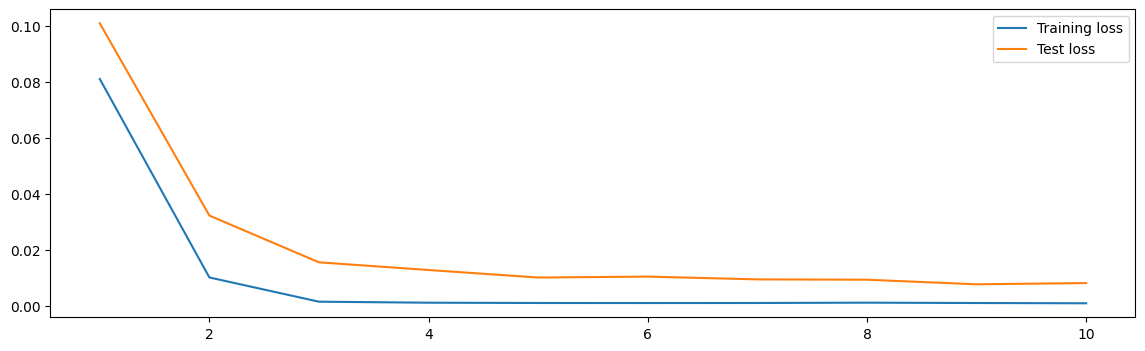

In [32]:
train(model, train_loader, test_loader)

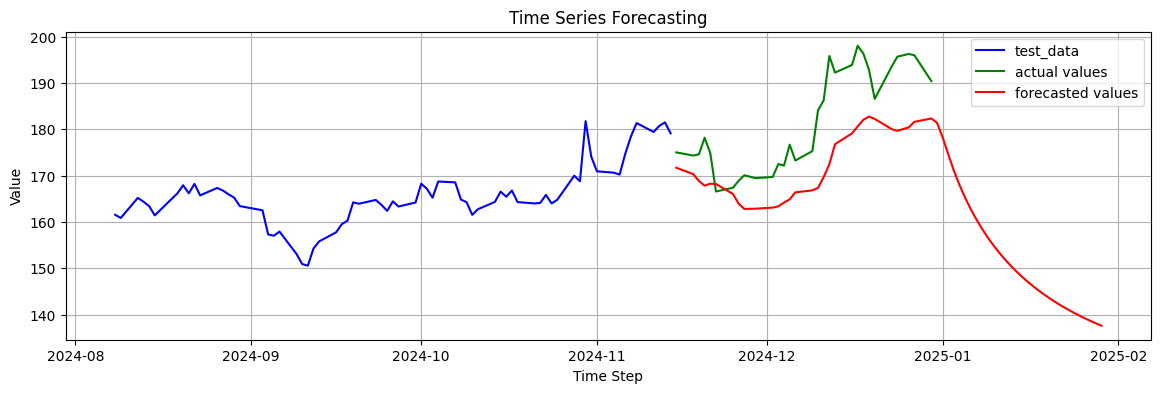

In [33]:
plot_forecasting(model, X_test, y_test)

In [34]:
rmse, mape = test(model, X_test, y_test)
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')

RMSE: 0.7518
MAPE: 0.6188


# Optional (Encoder-Decoder)

## Data Preprocessing

In [35]:
sequence_length = 50
target_len = 10

def create_enc_dec_sequences(data):
    features, labels = [], []
    for i in range(len(data) - sequence_length - target_len):
        features.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length : \
                           i + sequence_length + target_len])

    features = np.array(features, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    return features, labels

X_train_, y_train_ = create_enc_dec_sequences(train_scaled)
X_test_, y_test_ = create_enc_dec_sequences(test_scaled)
print(X_train_.shape)
print(y_train_.shape)
print(X_test_.shape)
print(y_test_.shape)

train_loader_ = to_loader(X_train_, y_train_, batch_size, shuffle=True)
test_loader_ = to_loader(X_test_, y_test_, batch_size, shuffle=False)

torch.Size([946, 50, 1])
torch.Size([946, 10, 1])
torch.Size([191, 50, 1])
torch.Size([191, 10, 1])


## Encoder-Decoder Structure

In [53]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        _, hidden = self.rnn(x)
        return hidden  # [num_layers, batch, hidden_size]

class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1, bias=True)

    def forward(self, x, h):
        out, h = self.rnn(x, h)
        y = self.fc(out[:, -1, :])  # [batch, 1]
        y = y.unsqueeze(1)          # [batch, 1, 1] for next input
        return y, h

class RNNRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(RNNRNN, self).__init__()
    self.encoder = EncoderRNN(input_size, hidden_size, num_layers)
    self.decoder = DecoderRNN(input_size, hidden_size, num_layers)

  def forward(self, source, target_len):
    h = self.encoder(source)
    predictions = []
    input = source[:, -1, :].unsqueeze(1)
    for t in range(target_len):
      out, h = self.decoder(input, h)
      predictions.append(out.squeeze(1))
      input = out
    outputs = torch.stack(predictions, dim=1)

    return outputs

model_ = RNNRNN(input_size, hidden_size, num_layers).to(device)
print(model_)
# RNNRNN(
#   (encoder): EncoderRNN(
#     (rnn): RNN(1, 64, num_layers=2, batch_first=True)
#   )
#   (decoder): DecoderRNN(
#     (rnn): RNN(1, 64, num_layers=2, batch_first=True)
#     (fc): Linear(in_features=64, out_features=1, bias=True)
#   )
# )

RNNRNN(
  (encoder): EncoderRNN(
    (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  )
  (decoder): DecoderRNN(
    (rnn): RNN(1, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Train

Epoch  1/10 - Training Loss: 0.1236, Test Loss: 0.3087
Epoch  2/10 - Training Loss: 0.0452, Test Loss: 0.1533
Epoch  3/10 - Training Loss: 0.0060, Test Loss: 0.0532
Epoch  4/10 - Training Loss: 0.0030, Test Loss: 0.0422
Epoch  5/10 - Training Loss: 0.0031, Test Loss: 0.0310
Epoch  6/10 - Training Loss: 0.0036, Test Loss: 0.0369
Epoch  7/10 - Training Loss: 0.0032, Test Loss: 0.0482
Epoch  8/10 - Training Loss: 0.0032, Test Loss: 0.0307
Epoch  9/10 - Training Loss: 0.0030, Test Loss: 0.0428
Epoch 10/10 - Training Loss: 0.0029, Test Loss: 0.0400


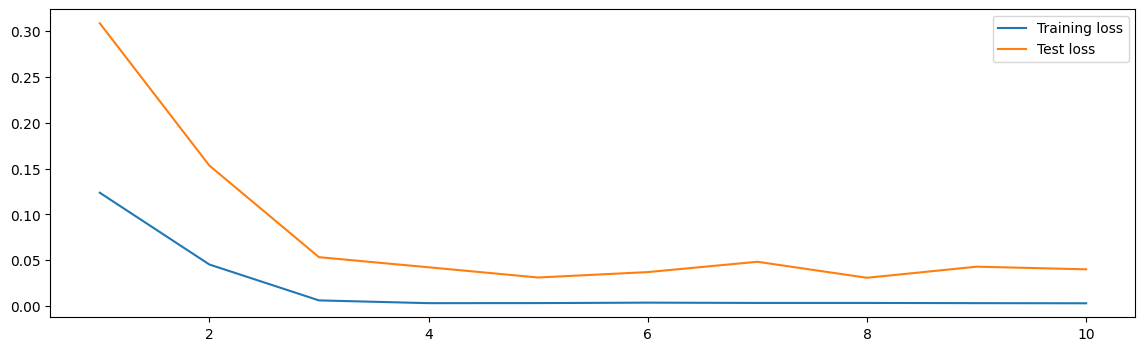

In [54]:
def train_(model, train_loader, test_loader):
  train_hist = []
  test_hist = []
  num_epochs = 10
  loss_fn = nn.MSELoss(reduction='mean')
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_test_loss = 0.0

    # train
    model.train()
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      pred = model(batch_x, batch_y.shape[1])
      loss = loss_fn(pred, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

    avg_loss = total_train_loss / len(train_loader)
    train_hist.append(avg_loss)

    # evaluate
    model.eval()
    with torch.no_grad():
      for test_x, test_y in test_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_pred = model(test_x, target_len)
        test_loss = loss_fn(test_pred, test_y)
        total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_hist.append(avg_test_loss)

    print(f'Epoch {epoch + 1:2d}/{num_epochs} - Training Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

  x = np.linspace(1, num_epochs, num_epochs)
  plt.plot(x, train_hist, scalex=True, label="Training loss")
  plt.plot(x, test_hist, label="Test loss")
  plt.legend()

train_(model_, train_loader_, test_loader_)

## Plot Forecasting


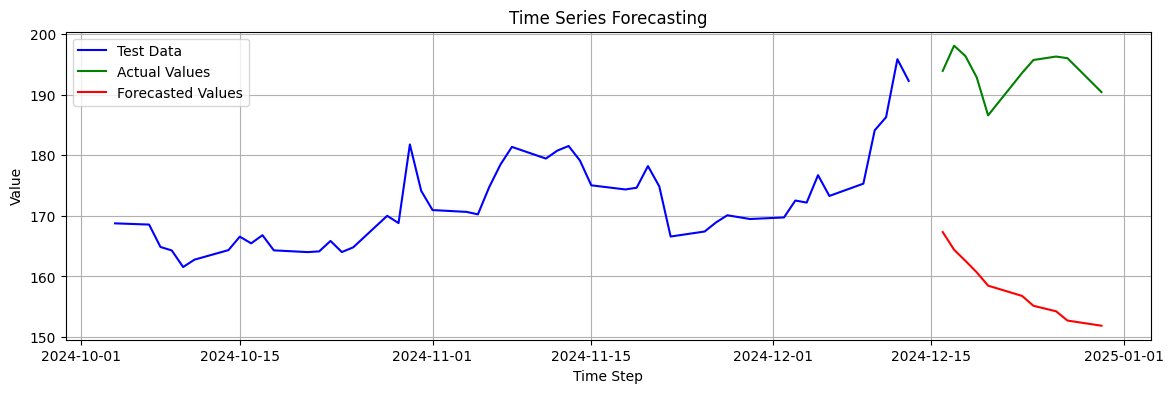

In [55]:
def plot_forecasting_(model, X_test, y_test):
  model.eval()
  input_tensor = X_test[-1].unsqueeze(0).to(device)

  with torch.no_grad():
    predicted = model(input_tensor, target_len)
    forecasted_values = predicted.squeeze(0).cpu().numpy()

  forecasted_values = scaler.inverse_transform(forecasted_values.reshape(-1, 1))
  actual_values = scaler.inverse_transform(y_test[-1].cpu().numpy().reshape(-1, 1))

  plt.rcParams['figure.figsize'] = [14, 4]

  plt.plot(test_data.index[-60:-10], test_data[-60:-10], label="Test Data", color="b")
  plt.plot(test_data.index[-10:], test_data.iloc[-10:], label='Actual Values', color='green')

  plt.plot(test_data.index[-10:], forecasted_values, label='Forecasted Values', color='red')

  plt.xlabel('Time Step')
  plt.ylabel('Value')
  plt.legend()
  plt.title('Time Series Forecasting')
  plt.grid(True)

plot_forecasting_(model_, X_test_, y_test_)

## Test


In [56]:
def test_(model, X_test, y_test):
  model.eval()
  with torch.no_grad():
      test_predictions = []
      for batch_X_test in X_test:
          batch_X_test = batch_X_test.to(device).unsqueeze(0)
          test_predictions.append(model(batch_X_test, target_len).cpu().numpy().flatten())

  test_predictions = np.array(test_predictions)
  y_test = y_test.cpu().numpy().reshape(-1, target_len)

  rmse = root_mean_squared_error(y_test, test_predictions)
  mape = mean_absolute_percentage_error(y_test, test_predictions)

  return rmse, mape

rmse, mape = test_(model_, X_test_, y_test_)
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')

RMSE: 0.1951
MAPE: 0.1461
